we want to know for the samples that we have, are there sequences that are very closely related and are therefore likely to have originated from the same patient.

In [1]:
library(ape)
library(reshape)
library(igraph)
library(cluster)
library(phangorn)
library(Biostrings)
setwd('~/hbv_covar3/')


Attaching package: 'igraph'


The following objects are masked from 'package:ape':

    edges, mst, ring


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'phangorn'


The following object is masked from 'package:igraph':

    diversity


Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:igraph':

    normalize, path, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
 

In [2]:
cur_genotype = 'A'
seq_file = paste0('./QC/step1_mafft/HBV_', cur_genotype, '_nt_mafft.fasta')
hbv_seqs = read.dna(seq_file, as.matrix = T, as.character = T, format = 'fasta')
rownames(hbv_seqs) = unlist(lapply(rownames(hbv_seqs), function(x){
    paste0(strsplit(strsplit(x, '\\|')[[1]][3], '_')[[1]][1], '_', cur_genotype)
}))
hbv.dist = as.matrix(dist.hamming(as.phyDat(hbv_seqs), exclude = 'pairwise'))

### plot distribution of pairwise distance

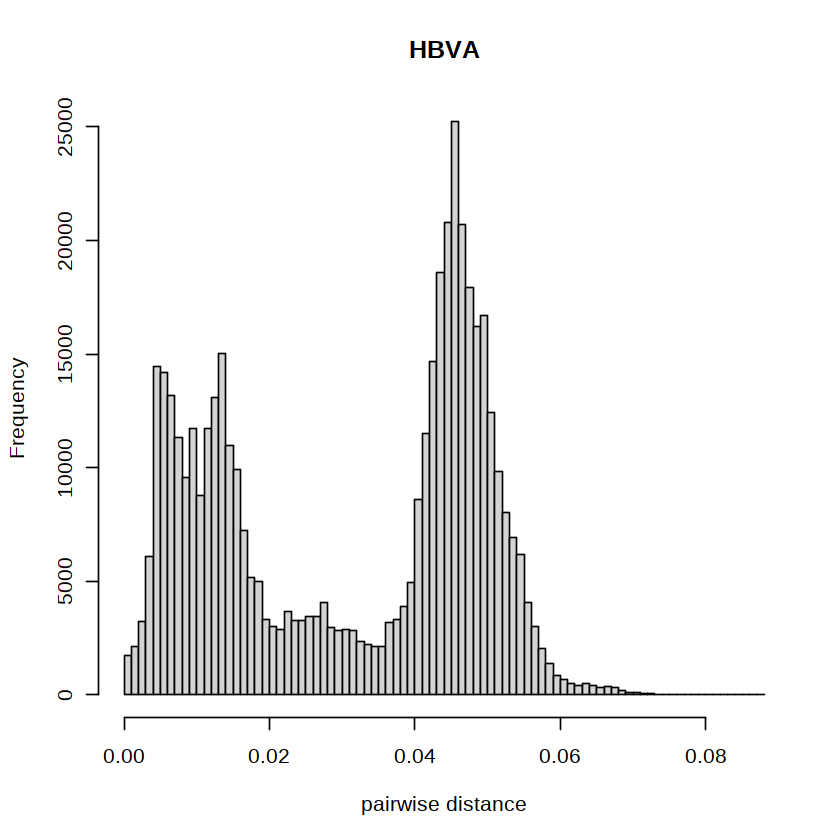

In [3]:
hbv.dist.lower = hbv.dist
hbv.dist.lower[upper.tri(hbv.dist, diag = T)] = NA
hist(unlist(hbv.dist.lower), 100, 
     main = paste0('HBV', cur_genotype),
     xlab = 'pairwise distance') 

### Identify duplication at 0.5% identity level

In [4]:
azimCut = 0.005
hbv.dist.norm = hbv.dist
# find clusters where maximum distance within a cluster is 0.5% nucelotide difference
azimCutHclust = hclust(as.dist(hbv.dist.norm))
azimCutClusters = cutree(azimCutHclust, h = azimCut)
uniqueSamples = names(azimCutClusters)[(which(!duplicated(azimCutClusters)))]
print(nrow(hbv_seqs))
print(length(uniqueSamples))

[1] 970
[1] 453


### For each cluster of potential duplicates, pick the one with the most unambiguous nt

In [154]:
include_names = vector()
for(i in 1:max(azimCutClusters)){
    samps = names(azimCutClusters)[which(azimCutClusters == i)]
    seqs =  hbv_seqs[samps,,drop = F]
    seqs_ambig_cnt = unlist(apply(seqs, 1, function(x){
        if ('-' %in% x){
            x = x[-which(x == '-')]
        }
        return(length(which(!(x %in% c('a', 'c', 't', 'g')))))
    }))
    include_names = c(include_names, rownames(seqs)[which.min(seqs_ambig_cnt)])
}

In [155]:
hbv_seqs_unique = hbv_seqs[include_names,]
dim(hbv_seqs_unique)

[1]   18 3215

### Clean up the naming of each sequence

In [156]:
write.dna(as.DNAbin(hbv_seqs_unique), paste0('./QC/step2_findDup/HBV_', cur_genotype,'_nodup05.fasta'), format = 'fasta', colsep = '')
write.dna(as.DNAbin(hbv_seqs_unique), paste0('./QC/step2_findDup/HBV_', cur_genotype,'_nodup05.phylip'), format = 'interleaved', colsep = '')

In [162]:
for (genotype in c('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')){
    temp = read.dna(paste0('./QC/step2_findDup/HBV_', genotype,'_nodup05.fasta'), format = 'fasta')
    write.dna(temp, paste0('./QC/step2_findDup/HBV_', genotype,'_nodup05.fasta'), format = 'fasta', colsep = '')
}

In [ ]:
## getting the consensus sequence